In [2]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe
import julian
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
#Bounding Box for Philippines
lonmin = 117.17427453
latmin = 5.58100332277
lonmax = 126.537423944
latmax = 18.5052273625

In [5]:
# function for Emanuel Vulnerability Curves

def vulnerability(V,Vthresh,Vhalf): # calculate fractional property value lost over space

    # V = Input wind speed swath; m/s
    
    # Vthresh = windspeed at and below which no damage occurs; m/s

    # Vhalf = windspeed at which half the property value is lost; m/s

    vn0 = V-Vthresh
    vn = np.maximum(vn0, np.zeros(np.shape(vn0)))/(Vhalf-Vthresh)
    f = vn**3/(1+vn**3)
    
    return f # vulnerability in all different regions

# Calculate swaths and save out:

In [4]:
# Calculate wind swaths and save out
nmax = 451
swath = np.zeros([nmax,130,94])
day1 = np.zeros([nmax])
year = np.zeros([nmax])
for n in np.arange(0,nmax,1):#np.arange(1,450,1):
    try:
        ds_haz = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/PHI_REG_TEST5/wspd_phi_'+str(n)+'.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax)) # select Philippines region
        swath[n,...] = np.abs(ds_haz.sel(nS=n).max(dim='iT').wspd) # take absolute value of wind speed, and calculate max across time points
        day1[n] = ds_haz.days[0,0]
        year[n] = ds_haz.year
    except FileNotFoundError: 
        pass
        

In [5]:
# Save out dataset of swaths
ds_swaths = xr.Dataset(
         {"swath": (("nS", "lat", "lon"), swath),
          "day1": (("nS"), day1),
          "year": (("nS"), year)},
             coords={
            "nS":np.arange(0,nmax,1),
            "lat": ds_haz.lat,
            "lon": ds_haz.lon,
         },
         )


NameError: name 'ds_haz' is not defined

In [101]:
ds_swaths.to_netcdf('/data2/jbaldwin/WINDFIELDS/PHI_SWATHS/wspd_phi_swaths.nc',mode='w')

In [102]:
#341/450 of wind fields saved out.
np.sum(np.sum(np.sum(swath,axis=1),axis=1)>0)

451

# Open up swaths:

In [6]:
ds_swaths = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_swaths.nc')
swath = ds_swaths.swath

In [7]:
# Convert modified Julian days to date-time objects
nmax = 451
dt = []
month = np.zeros(nmax)
day = np.zeros(nmax)
for n in np.arange(0,nmax,1):
    mjd = ds_swaths.days[n,0]
    x = julian.from_jd(mjd, fmt='mjd').date()
    dt.append(x)
    month[n] = int(x.month)
    day[n] = int(x.day)
year = ds_swaths.year.values
    

In [8]:
# Stats on most destructive Philippines TCs
name_des = ['Haiyan (Yolanda)','Bopha (Pablo)','Rammasun (Glenda)','Parma (Pepeng)','Nesat (Pedring)','Koppu (Lando)','Fengshen (Frank)','Megi (Juan)','Ketsana (Ondoy)']
# Day before date of Phi landfall
dt_des = [datetime.date(2013,11,6),datetime.date(2012,12,2),datetime.date(2014,7,14),datetime.date(2009,10,2),datetime.date(2011,9,25),datetime.date(2015,10,16),datetime.date(2008,6,19),datetime.date(2010,10,17),datetime.date(2009,9,25)]
cost_des = [2.2e9,1.06e9,885e6,581e6,356e6,313e6,304e6,278e6,233e6]


# Start here picking out swaths of destructive storms.

In [9]:
# Select swath for each destructive storm
nmax_des = len(name_des)
swath_des = np.zeros([nmax_des,np.shape(ds_swaths.swath)[1],np.shape(ds_swaths.swath)[2]])
n_des = np.zeros(nmax_des)
for i in np.arange(len(name_des)):
    try:
        n_des[i] = dt.index(dt_des[i])
        swath_des[i,...] = swath[int(n_des[i]),...].values
    except ValueError:
        pass
    

In [10]:
# Save out dataset of swath_des
ds_swaths_des = xr.Dataset(
         {"swath": (("nS", "lat", "lon"), swath_des)},
             coords={
            "nS":np.arange(len(name_des)),
            "lat": ds_swaths.lat,
            "lon": ds_swaths.lon,
         },
         )

ds_swaths_des.to_netcdf('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_swaths_des.nc',mode='w')

In [11]:
# Exposed Value Data, subset over Philippines
ds_exp = xr.open_dataset('EXPOSED_VALUE/LitPopExposure_World.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
exposed_value = ds_exp.data
#ds_exp = xr.open_dataset('EXPOSED_VALUE/asia_exposed_value_reduced.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
#exposed_value = ds_exp.exposed_value


In [12]:
# Determine Regridder for Hazard --> Exposed Value
regridder = xe.Regridder(swath, ds_exp, 'bilinear',reuse_weights=True)


Reuse existing file: bilinear_146x111_1551x1124.nc


In [13]:
# Regrid wind swath
swath_des = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_swaths_des.nc').swath
swath_out_des = regridder(swath_des)


In [14]:
# Calculate asset losses

Vthresh = 25.7# Eberenz et al 2020, value for Philippines; m/s
Vhalf = 84.7# Eberenz et al 2020, value for Philippines using RMSF calculation; m/s
V = swath_out_des

f = vulnerability(V,Vthresh,Vhalf)

asset_losses = exposed_value*f


In [15]:
# Calculate total cost for storm over Philippines
est_cost = np.sum(np.sum(asset_losses,axis=0),axis=0)


Text(0.5, 1.0, 'Cost vs Est. Cost of\n9 Very Destructive TCs in Philippines')

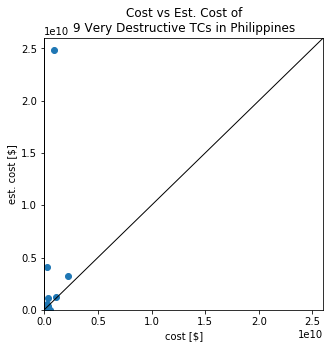

In [16]:
# Zoom out plot to include all points
plt.figure(figsize=(5, 5))
plt.scatter(cost_des,est_cost)
plt.xlabel('cost [$]')
plt.ylabel('est. cost [$]')
plt.plot([-1e10,3e10],[-1e10,3e10],color='k',linewidth=1)
plt.xlim([0,2.6e10])
plt.ylim([0,2.6e10])
plt.hlines(0,-0.5e20,2.5e20,linewidth=1)
plt.vlines(0,-0.5e20,2.5e20,linewidth=1)
plt.title('Cost vs Est. Cost of\n9 Very Destructive TCs in Philippines')

Text(0.5, 1.0, 'Cost vs Est. Cost of\n9 Very Destructive TCs in Philippines')

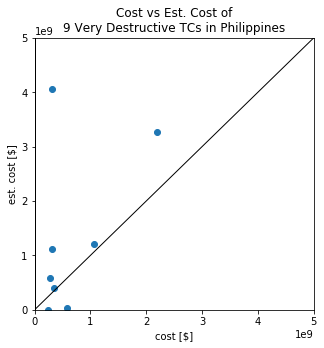

In [17]:
# Zoom in plot
plt.figure(figsize=(5, 5))
plt.scatter(cost_des,est_cost)
plt.xlabel('cost [$]')
plt.ylabel('est. cost [$]')
plt.plot([-1e10,3e10],[-1e10,3e10],color='k',linewidth=1)
plt.xlim([0,5e9])
plt.ylim([0,5e9])
plt.hlines(0,-0.5e20,2.5e20,linewidth=1)
plt.vlines(0,-0.5e20,2.5e20,linewidth=1)
plt.title('Cost vs Est. Cost of\n9 Very Destructive TCs in Philippines')

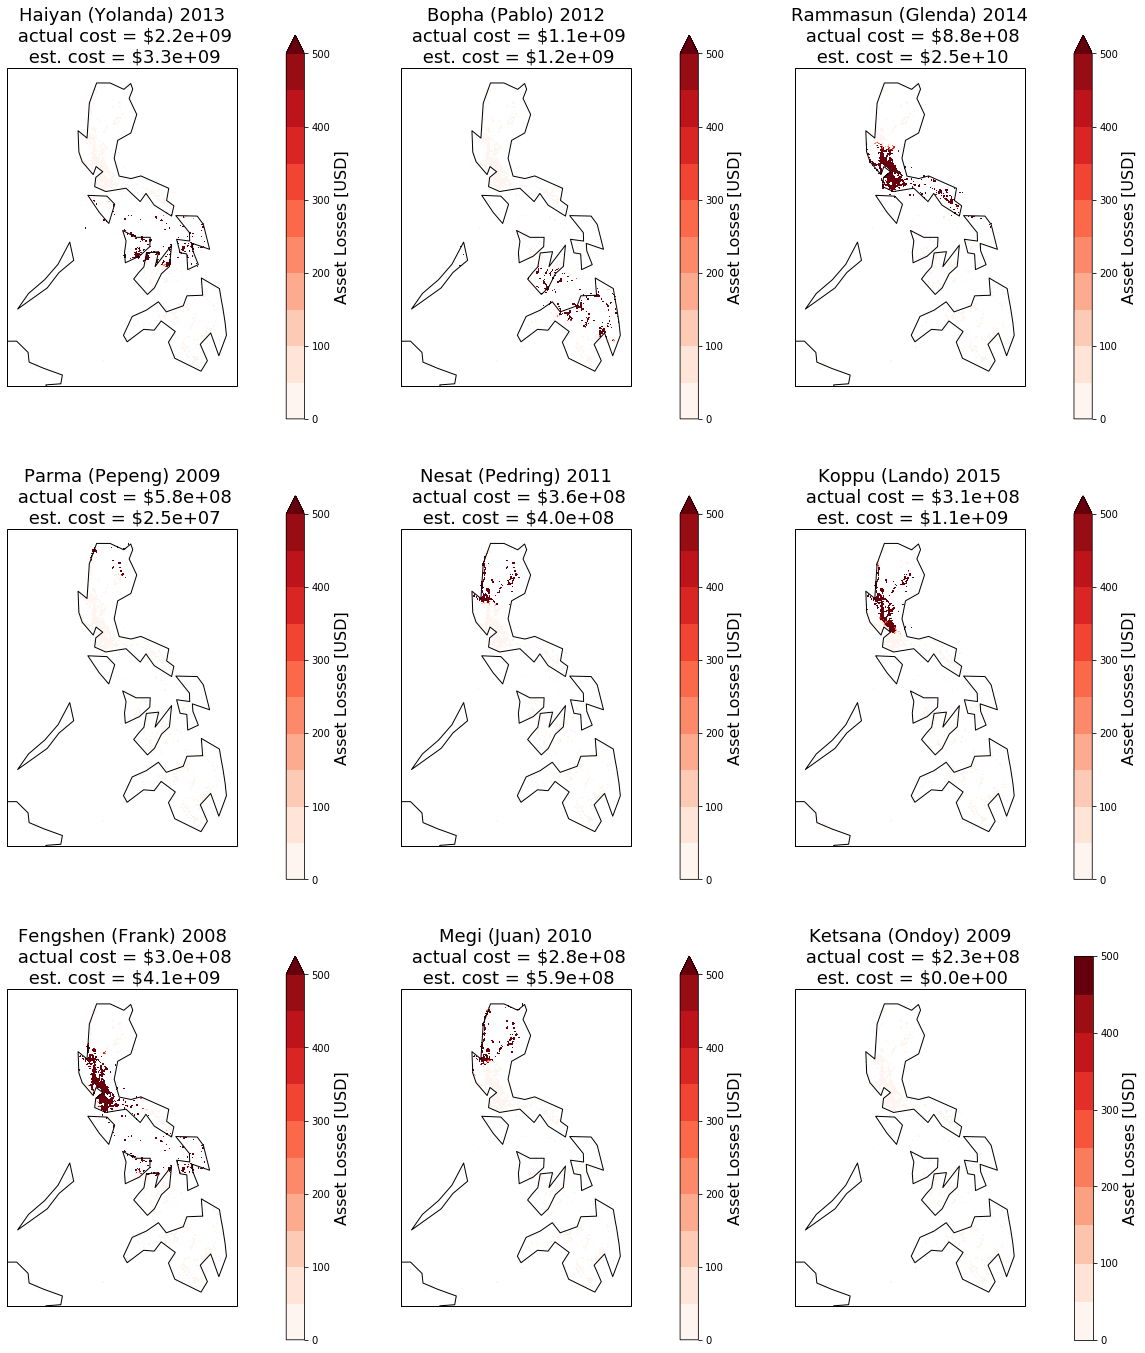

In [43]:
plt.figure(figsize=(20, 24))
for n in np.arange(len(name_des)):
    plt.subplot(3,3,n+1,projection=ccrs.PlateCarree())
    p = asset_losses[...,n].plot(levels=np.arange(0,550,50),transform=ccrs.PlateCarree(),cmap=plt.cm.Reds,add_colorbar=False)
    p.axes.coastlines()
    plt.title(name_des[n]+' '+str(dt_des[n].year)+'\n actual cost = $'+"{:.1e}".format(int(cost_des[n]),decimals=1)+'\n est. cost = $'+"{:.1e}".format(int(est_cost[n])),fontsize=18)
    cb = plt.colorbar(p, orientation="vertical", pad=0.15)
    cb.set_label(label='Asset Losses [USD]',fontsize=16)

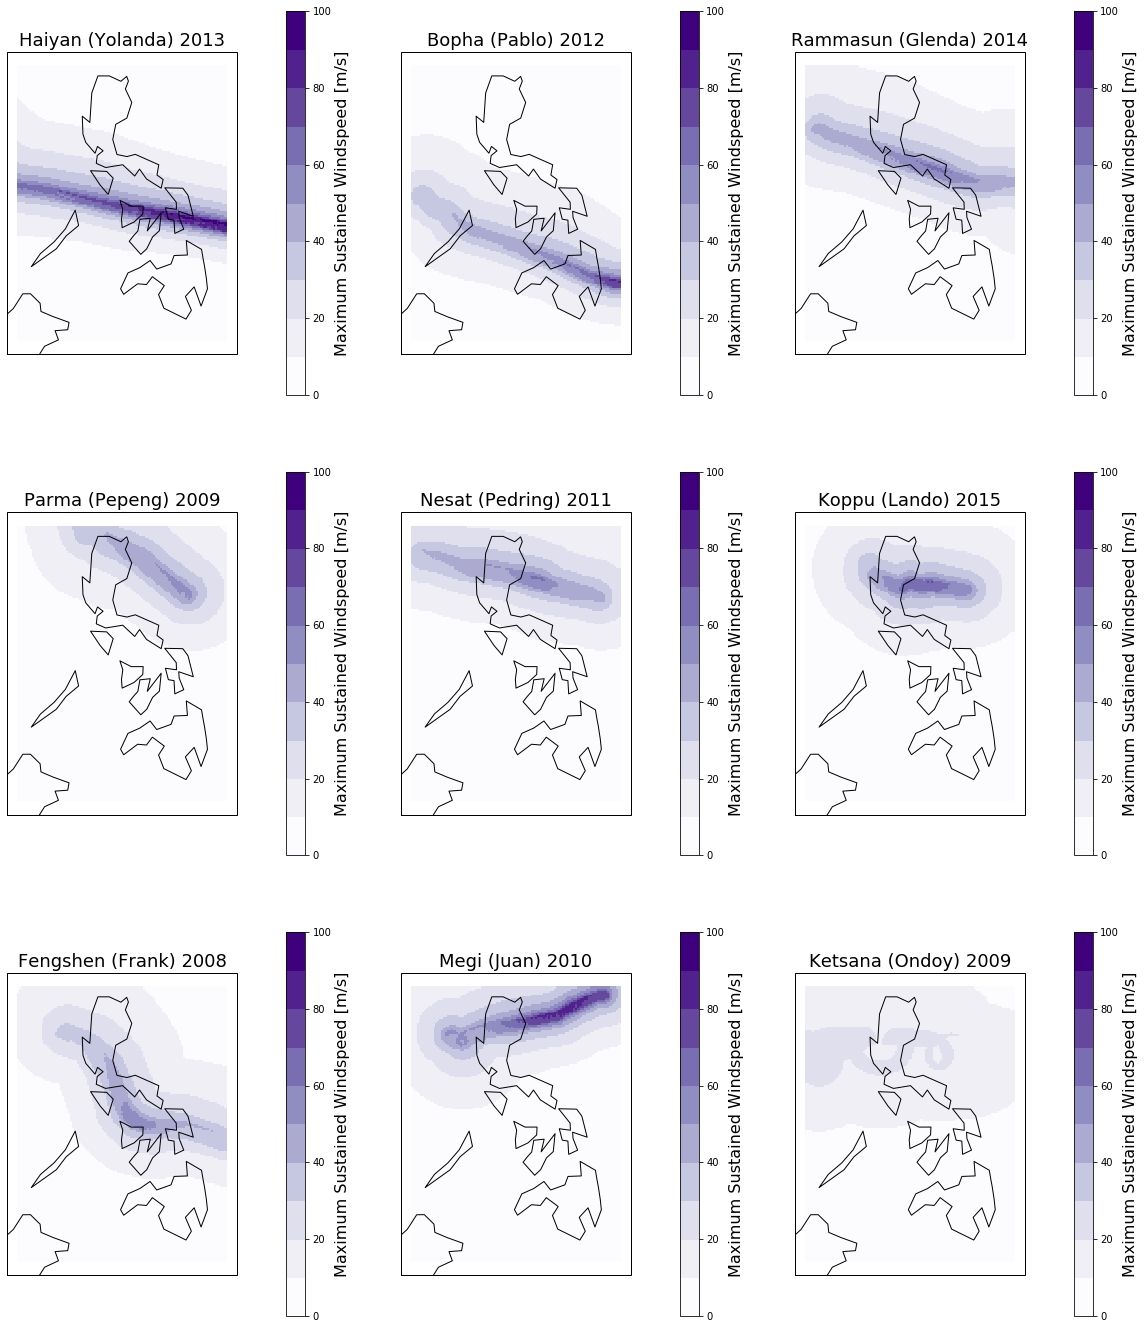

In [44]:
plt.figure(figsize=(20, 24))
for n in np.arange(len(name_des)):
    ax = plt.subplot(3,3,n+1,projection=ccrs.PlateCarree())
    p = swath_des[n].plot(transform=ccrs.PlateCarree(),cmap = plt.cm.Purples,levels=np.arange(0,110,10),add_colorbar=False)
    plt.title(name_des[n]+' '+str(dt_des[n].year),fontsize=18)
    ax.coastlines(color='k')
    cb = plt.colorbar(p, orientation="vertical", pad=0.15)
    cb.set_label(label='Maximum Sustained Windspeed [m/s]',fontsize=16)

In [ ]:
# Next Steps:
# Calculate losses for every storm I have, and save out in one netcdf file
# Calculate and plot losses for top 10 storms over Philippines, with total cost at top
# https://en.wikipedia.org/wiki/Typhoons_in_the_Philippines


# Calculate Asset Losses for Each Historical Storm

In [21]:
# Regrid wind swath
swath_out = regridder(swath)

In [23]:
# Calculate asset losses

Vthresh = 25.7# Eberenz et al 2020, value for Philippines; m/s
Vhalf = 84.7# Eberenz et al 2020, value for Philippines using RMSF calculation; m/s
V = swath_out

f = vulnerability(V,Vthresh,Vhalf)

asset_losses = exposed_value*f

In [25]:
# Save out dataset of asset losses with dates
ds_asset_losses = xr.Dataset(
         {"asset_losses": (("lat", "lon", "nS"), asset_losses.values),
         "year": (("nS"), year),
         "month": (("nS"), month),
         "day": (("nS"), day)},
             coords={
            "nS":asset_losses.nS,
            "lat":asset_losses.lat,
            "lon":asset_losses.lon,
         },
         )

ds_asset_losses.to_netcdf('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_assetlosses.nc',mode='w')

# Calculate all Philippines return periods for asset losses

In [27]:
# Load data
ds_asset_losses = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI_SWATHS/wspd_phi_assetlosses.nc')
asset_losses = ds_asset_losses.asset_losses

In [28]:
# Calculate total cost for storm over Philippines
est_cost = np.sum(np.sum(asset_losses,axis=0),axis=0)

# Calculate number of years observed
obsy = (ds_asset_losses.year[-1]-ds_asset_losses.year[0]).values

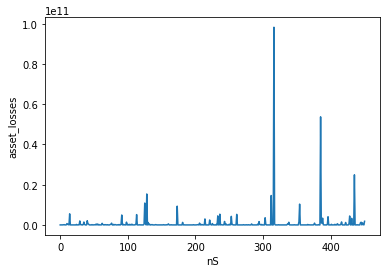

In [29]:
est_cost.plot()

Text(0, 0.5, 'Est. Cost Across Philippines [USD]')

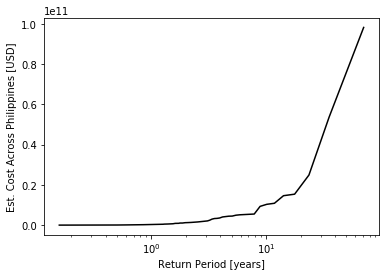

In [30]:
ax1 = plt.subplot(111)
obsw = est_cost
pdfevents,bins = np.histogram(obsw,np.unique(np.hstack([np.sort(obsw),obsw.max()+5]))) # determine frequency in each bin
cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
returnP_o = 1./cdfevents # calculate return period (1/f)
dot, = ax1.semilogx(returnP_o[:],bins[:-1],'k-',label='obs',zorder=20)
plt.xlabel('Return Period [years]')
plt.ylabel('Est. Cost Across Philippines [USD]')
